In [ ]:
!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
# !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/volumedata.tif
# !unzip 
#!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/results_test.tif

In [ ]:
# you can either download data or import it from google drive
# mount it
from google.colab import drive
drive.mount('/content/drive')
# save the data on your google drive
!cp /content/drive/MyDrive/training.tif /content/
!cp /content/drive/MyDrive/training_groundtruth.tif /content/ 

# load the Data from google drive
img = mtif.read_stack("/content/training.tif", units='um')
msk = mtif.read_stack("/content/training_groundtruth.tif", units='um')


In [ ]:
!pip install patchify
!pip install tensorflow-gpu
# !pip install tensorflow
!pip install keras
!pip install segmentation-models
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm

!pip install multipagetiff
import multipagetiff as mtif # in order to make small patches out of big images, I used multipagetiff 
from matplotlib import pyplot as plt


from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
patch_size = 256 # the size of patches

image_dataset = []  # preparing dataset(images) 
for k in range(img.shape[0]):
  patches_img = patchify(img[k,:,:], (patch_size, patch_size), step=patch_size)  # extracing patches with no overlap
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,:,:]

      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

      image_dataset.append(single_patch_img)

mask_dataset = []   # preparing dataset(masks) 
for k in range(msk.shape[0]):
  patches_mask = patchify(msk[k,:,:], (patch_size, patch_size), step=patch_size)  # extracing patches with no overlap
  for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
        
        single_patch_mask = patches_mask[i,j,:,:]
        mask_dataset.append(single_patch_mask)


'''#Normalize images  ''' # these data are already normalized but this step is crucial 
image_dataset = np.expand_dims(np.array(image_dataset),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)


     |████████████████████████████████| 497.5 MB 26 kB/s 
     |████████████████████████████████| 462 kB 51.0 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
Segmentation Models: using `keras` framework.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


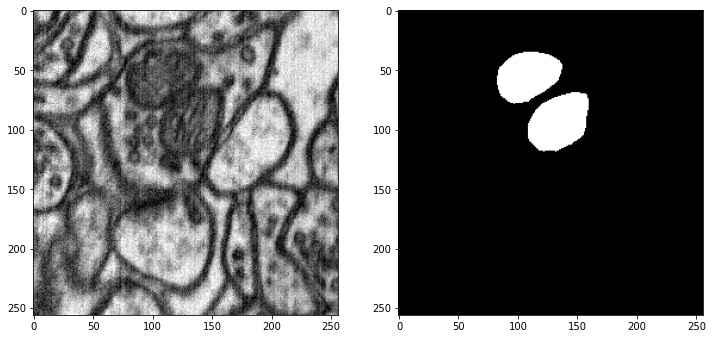

In [ ]:
#Sanity check, to check if images and masks are matching 
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show() 

In [ ]:
# simple u-net model function

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return 

In [ ]:
# u-net model with jaccard coefficient function

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

################################################################
def simple_unet_model_with_jacard(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer = 'adam', loss = [jacard_coef_loss], metrics = [jacard_coef])

    model.summary()
    
    return model

In [ ]:
###############################################################
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

def get_jacard_model():
    return simple_unet_model_with_jacard(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model_jacard = get_jacard_model()

def get_standard_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model_standard = get_standard_model()

#If starting with pre-trained weights. 
#model.load_weights('mitochondria_with_jacard_50_epochs.hdf5')

history_jacard = model_jacard.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model_jacard.save('mitochondria_with_jacard.hdf5')


history_standard = model_standard.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model_jacard.save('mitochondria_with_jacard.hdf5')
model_standard.save('mitochondria_standard.hdf5')
#To be compared with trained model mitochondria_gpu_tf1.4.hdf5
# that just used cross entropy for loss and accuracy for metric. 


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 256, 256, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

AttributeError: ignored

In [ ]:
model_jacard.save('mitochondria_with_jacard.hdf5')
# mount it
from google.colab import drive
drive.mount('/content/drive')
# copy it there
!cp mitochondria_with_jacard.hdf5 /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
